## Add redshift errors to the cubicBox

In [8]:
import os
os.environ["MPICH_GPU_SUPPORT_ENABLED"] = "0"
import sys
import fitsio
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.cm import get_cmap
import matplotlib.gridspec as gridspec
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 12
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# from desitarget.targetmask import desi_mask, bgs_mask
# from desitarget.targetmask import zwarn_mask as zmtl_zwarn_mask
from mockfactory import utils, DistanceToRedshift, Catalog, RandomBoxCatalog
from pyrecon import MultiGridReconstruction, IterativeFFTReconstruction, IterativeFFTParticleReconstruction, utils, setup_logging

sys.path.append('/global/homes/s/shengyu/project_rc/main/Y3/')
from helper import REDSHIFT_LSS_VSMEAR, REDSHIFT_LSS_CUBICBOX, EDGES, COLOR_TRACERS, REDSHIFT_VSMEAR, GET_RECON_BIAS
from Y3_redshift_systematics import vsmear, vsmear_modelling, vsmear_modelling_slitless_internal
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
boxsize = 2000.
tracer = 'BGS'
z_cubic = REDSHIFT_LSS_CUBICBOX[tracer][0]
(zmin, zmax) = REDSHIFT_LSS_VSMEAR[tracer][0]

base_dir = '/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/BGS/z0.200/AbacusSummit_base_c000_ph000'
catalog_fn = base_dir+'/BGS_box_ph000.fits'
catalog = Catalog.read(catalog_fn, filetype='fits')
print(catalog.columns)
print(len(catalog))

<bound method BaseCatalog.columns of Catalog(csize=232248642, size=232248642, columns=['R_MAG_ABS', 'G_R_REST', 'HALO_MASS', 'cen', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'FILE_NUM', 'HALO_ID'])>
232248642


BGS1:  RMS=35.0, median=14.10563904164732, fc = 0.45%
LRG1:  RMS=54.2, median=26.979899773134036, fc = 1.03%
LRG2:  RMS=74.4, median=39.334263020399874, fc = 0.85%
LRG3:  RMS=99.1, median=56.61700429196037, fc = 0.88%
ELG1:  RMS=19.3, median=6.5979697178858405, fc = 0.26%
ELG2:  RMS=30.9, median=10.03303584735878, fc = 0.43%
QSO1:  RMS=508.8, median=97.20825974225296, fc = 1.42%


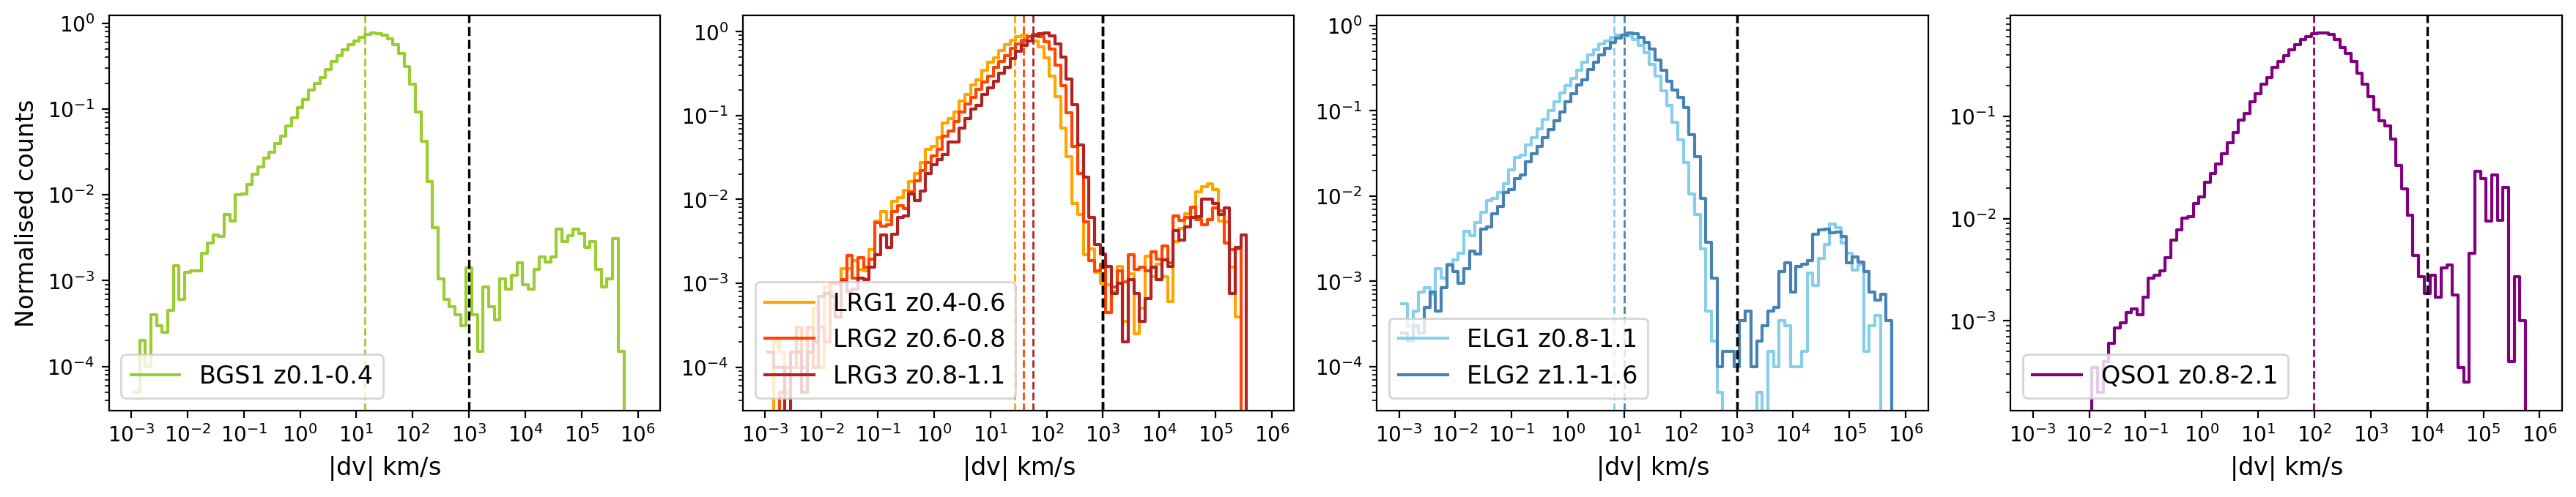

In [10]:
fig = plt.figure(figsize=(18, 3))
gs = gridspec.GridSpec(1,4,wspace=0.15,hspace=0.1,left=0.05, right=0.98, top=0.95, bottom=0.05)

lss = ['-', '-', '-']
# colormap = plt.cm.viridis
colormap = plt.cm.plasma
for i,tracer in enumerate(['BGS','LRG','ELG','QSO']):
    ax = plt.subplot(gs[i])
    for zind,(zmin,zmax) in enumerate(REDSHIFT_LSS_VSMEAR[tracer]):
        # colors = colormap(np.linspace(0, 1, len(REDSHIFT_LSS_VSMEAR[tracer])+2))
        color = COLOR_TRACERS[tracer][zind]
        catasmin, catasmax, catasbin = -3, 6.1, 0.1
        dv = vsmear(tracer, zmin=zmin, zmax=zmax, Ngal=400000, seed = 42)
        logdv = np.log10(abs(dv))
        median_vsmear = np.median(abs(dv))
        catas_threshold = 10000 if tracer == 'QSO' else 1000
        f_catas = (np.sum(abs(dv) > catas_threshold)) /len(dv)
        RMS = np.sqrt(np.mean(dv[abs(dv) < catas_threshold]**2))
        dens, bins = np.histogram(logdv, bins=np.arange(catasmin,catasmax,catasbin), density= True)
        bins = (bins[1:]+bins[:-1])/2
        plt.semilogy(bins, dens, drawstyle='steps-post', label=f'{tracer}{zind+1} z{zmin}-{zmax}', linestyle=lss[zind], color = color)
        plt.axvline(x=np.log10(median_vsmear), color=color, linestyle='--', linewidth=1.0)
        print(f'{tracer}{zind+1}:  RMS={RMS:.1f}, median={median_vsmear}, fc = {f_catas*100:.2f}%')
        # plt.title(f'Y3 ELG_LOPnotqso {zmin:.1f}<z<{zmax:.1f}',fontsize=10)
        plt.axvline(x=4 if tracer == 'QSO' else 3, color='black', linestyle='--', linewidth=1.2)
        # plt.xlabel(r'$\log_{10}(|\rm{dv}|)$')
        plt.xlabel(r'$|\rm{dv}|$ km/s')
        if i == 0:
            plt.ylabel(r'Normalised counts')
        plt.yscale('log')
        from matplotlib import ticker
        ax = plt.gca() 
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: fr"$10^{{{int(x)}}}$"))
        # plt.legend(loc='center right')
        plt.legend(loc=3)

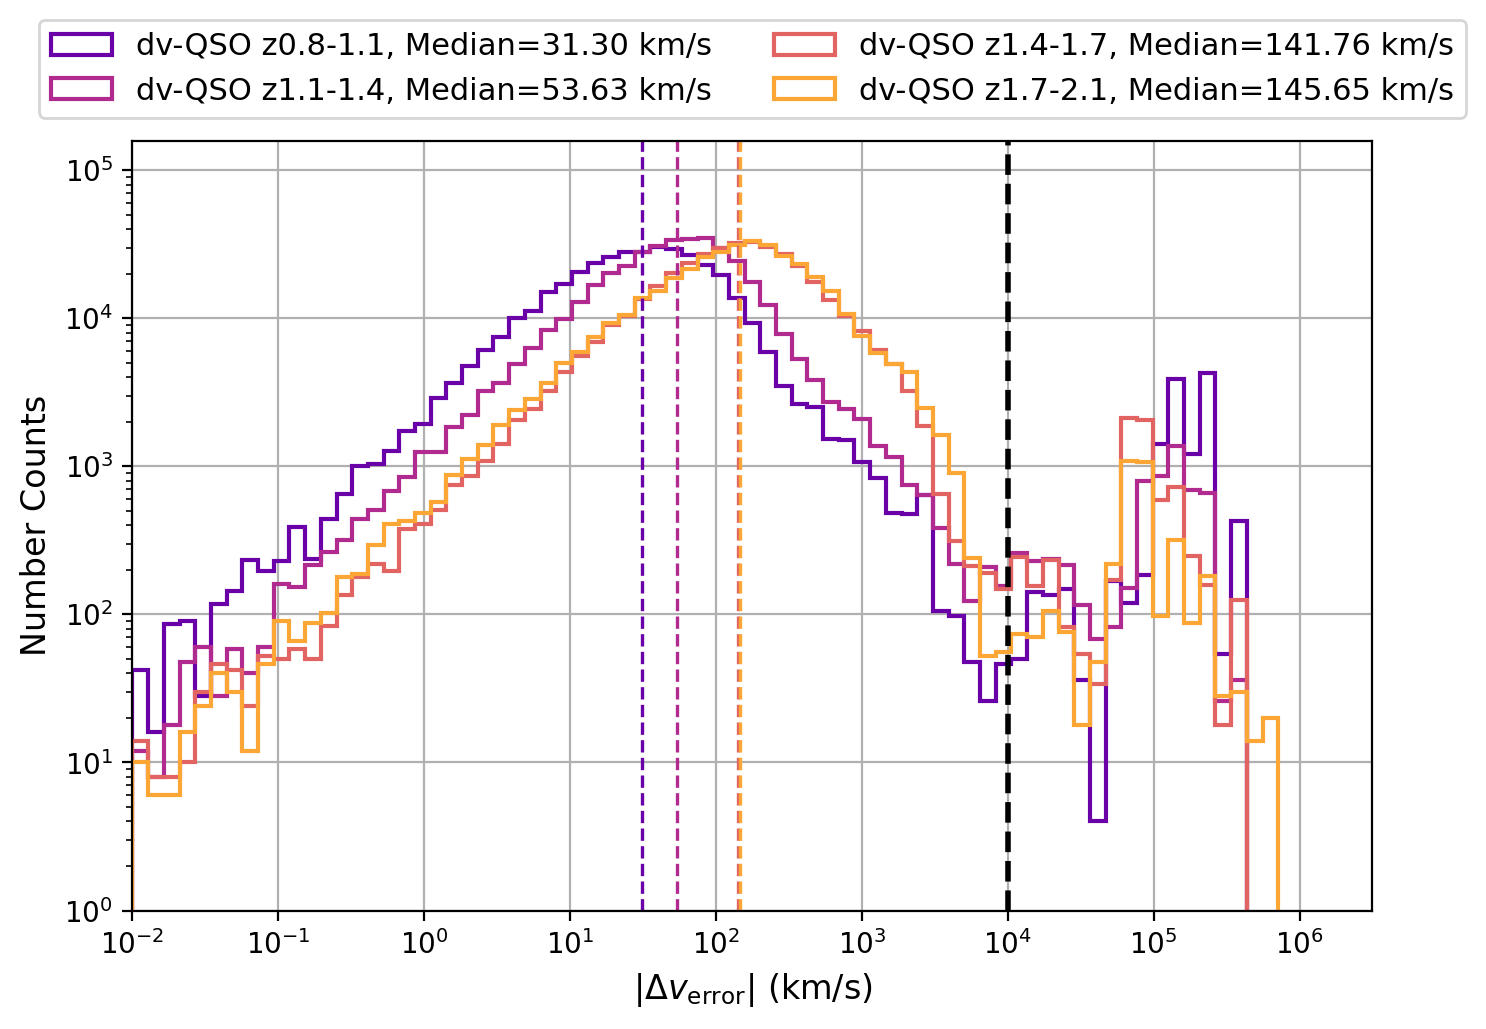

In [67]:
#redshift errors distribution for QSO
tracer = 'QSO'
catas = 1e5
num_zbins = len(REDSHIFT_VSMEAR[tracer])

NUM_bins = 80
fig = plt.figure(figsize = (8, 5))
# gs = gridspec.GridSpec(1, 1, wspace=0.22)
colormap = get_cmap('plasma')
colors = [tuple(c) for c in colormap(np.linspace(0, 1, num_zbins+2))] 

for zind, (zmin, zmax) in enumerate(REDSHIFT_VSMEAR['QSO']):
    logdv_min = -2
    logdv_max = 6.5
    dv = vsmear(tracer, zmin, zmax, 400000)
    logdv = np.log10(abs(dv))
    median_vsmear = 10**np.median(logdv)
    plt.hist(logdv, histtype='step', bins=np.linspace(logdv_min, logdv_max, NUM_bins),
            color= colors[zind+1], label = f'dv-QSO z{zmin}-{zmax}, Median={median_vsmear:.2f} km/s', lw = 1.5)
    plt.axvline(x=np.log10(median_vsmear), color=colors[zind+1], linestyle='--', linewidth=1.2)
plt.axvline(x=4 if tracer == 'QSO' else 3, color='black', linestyle='--', linewidth=2)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.01), fontsize=11, ncol=2)
plt.yscale('log')
plt.ylim([10**(0.), 10**(5.2)])
plt.xlim([-2, 6.5])
# plt.xlabel(r'$\log_{10}(|\Delta v_{\mathrm{error}}|)$ (km/s)')
plt.xlabel(r'$|\Delta v_{\mathrm{error}}|$ (km/s)')
from matplotlib import ticker
ax = plt.gca() 
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: fr"$10^{{{int(x)}}}$"))
plt.ylabel('Number Counts')
plt.grid(True)

In [42]:
data = np.column_stack((np.array(zmins+zmaxs)/2, RMS))
np.savetxt('../results/DESI_DR2_QSO_redshift_error_points.txt', data, 
           header="redshift, RMS of QSO vsmear(km/s)", delimiter=", ", fmt="%.2f, %.8f")

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 1

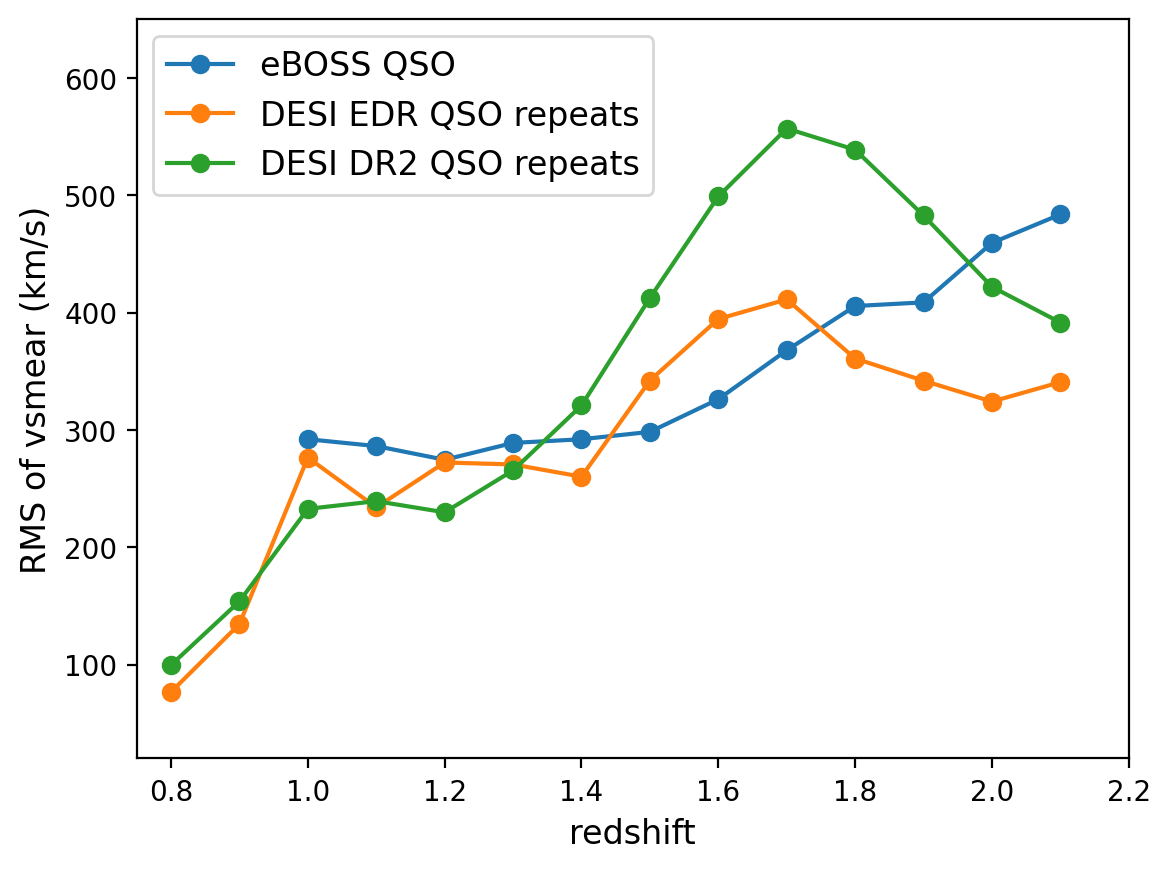

In [7]:
eBOSS_QSO_data = np.loadtxt('../results/eBOSS_QSO_redshift_error_points.txt', delimiter=',', skiprows=1)
plt.plot(eBOSS_QSO_data[:,0],  eBOSS_QSO_data[:,1],  '-o', label = 'eBOSS QSO')

EDR_QSO_data = np.loadtxt('../results/DESI_EDR_QSO_redshift_error_points.txt', delimiter=',', skiprows=1)
sel = (EDR_QSO_data[:,0]<2.2)&(EDR_QSO_data[:,0]>0.7)
plt.plot(EDR_QSO_data[:,0][sel],  EDR_QSO_data[:,1][sel],  '-o',label = 'DESI EDR QSO repeats')

DR2_QSO_data = np.loadtxt('../results/DESI_DR2_QSO_redshift_error_points.txt', delimiter=',', skiprows=1)
sel = (DR2_QSO_data[:,0]<2.2)&(DR2_QSO_data[:,0]>0.7)
plt.plot(DR2_QSO_data[:,0][sel],  DR2_QSO_data[:,1][sel],  '-o', label = 'DESI DR2 QSO repeats')

plt.ylabel('RMS of vsmear (km/s)')
plt.xlabel('redshift')
plt.ylim(20, 650)
plt.xlim(0.75, 2.2)
plt.legend()

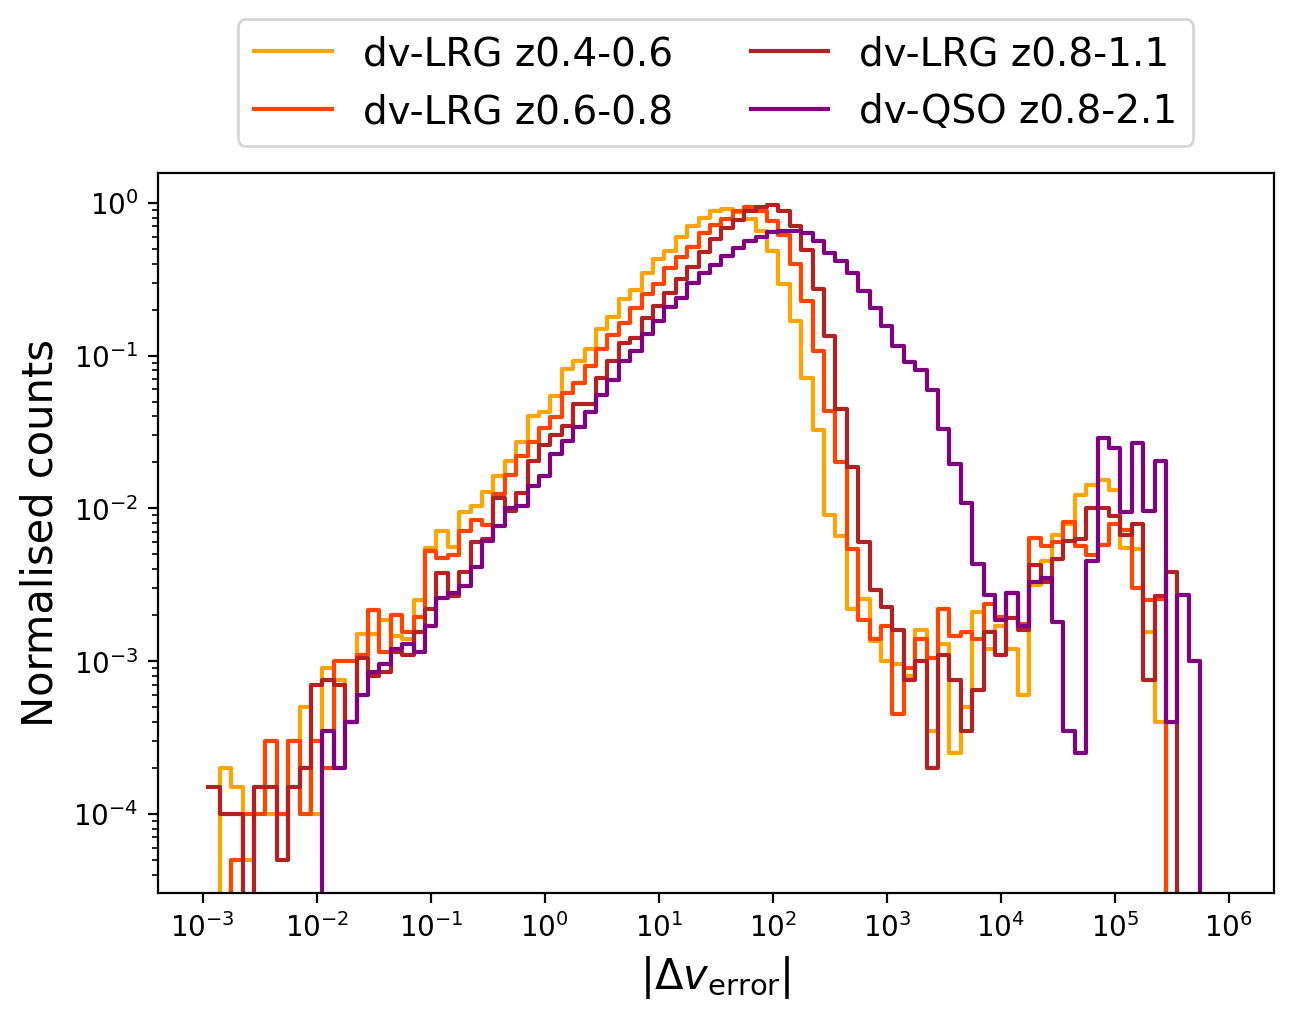

In [38]:
fig = plt.figure(figsize=(6, 4))
gs = gridspec.GridSpec(1,1,wspace=0.15,hspace=0.1,left=0.05, right=0.98, top=0.95, bottom=0.05)

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['legend.fontsize'] = 14

lss = ['-', '-', '-']
# colormap = plt.cm.viridis
colormap = plt.cm.plasma
for i,tracer in enumerate(['LRG','LRG','LRG','QSO']):
    ax = plt.subplot(gs[0])
    if tracer == 'QSO':
        i = 0
    color = COLOR_TRACERS[tracer][i]
    (zmin,zmax) = REDSHIFT_LSS_VSMEAR[tracer][i]
    # colors = colormap(np.linspace(0, 1, len(REDSHIFT_LSS_VSMEAR[tracer])+2))
    catasmin, catasmax, catasbin = -3, 6.1, 0.1
    dv = vsmear(tracer, zmin=zmin, zmax=zmax, Ngal=400000, seed = 42)
    logdv = np.log10(abs(dv))
    dens, bins = np.histogram(logdv, bins=np.arange(catasmin,catasmax,catasbin), density= True)
    bins = (bins[1:]+bins[:-1])/2
    plt.semilogy(bins, dens, drawstyle='steps-post', label=f'dv-{tracer} z{zmin}-{zmax}', color = color)
    # plt.title(f'Y3 ELG_LOPnotqso {zmin:.1f}<z<{zmax:.1f}',fontsize=10)
    # plt.axvline(x=3, color='black', linestyle='--', label='catas line')
    plt.xlabel(r'$|\Delta v_{\rm{error}}|$')
    # plt.xlabel(r'$\log_{10}(|v|)$')
    ax = plt.gca() 
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: fr"$10^{{{int(x)}}}$"))
    if i == 0:
        plt.ylabel('Normalised counts')
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.01), fontsize=14, ncol=2)
    plt.yscale('log')

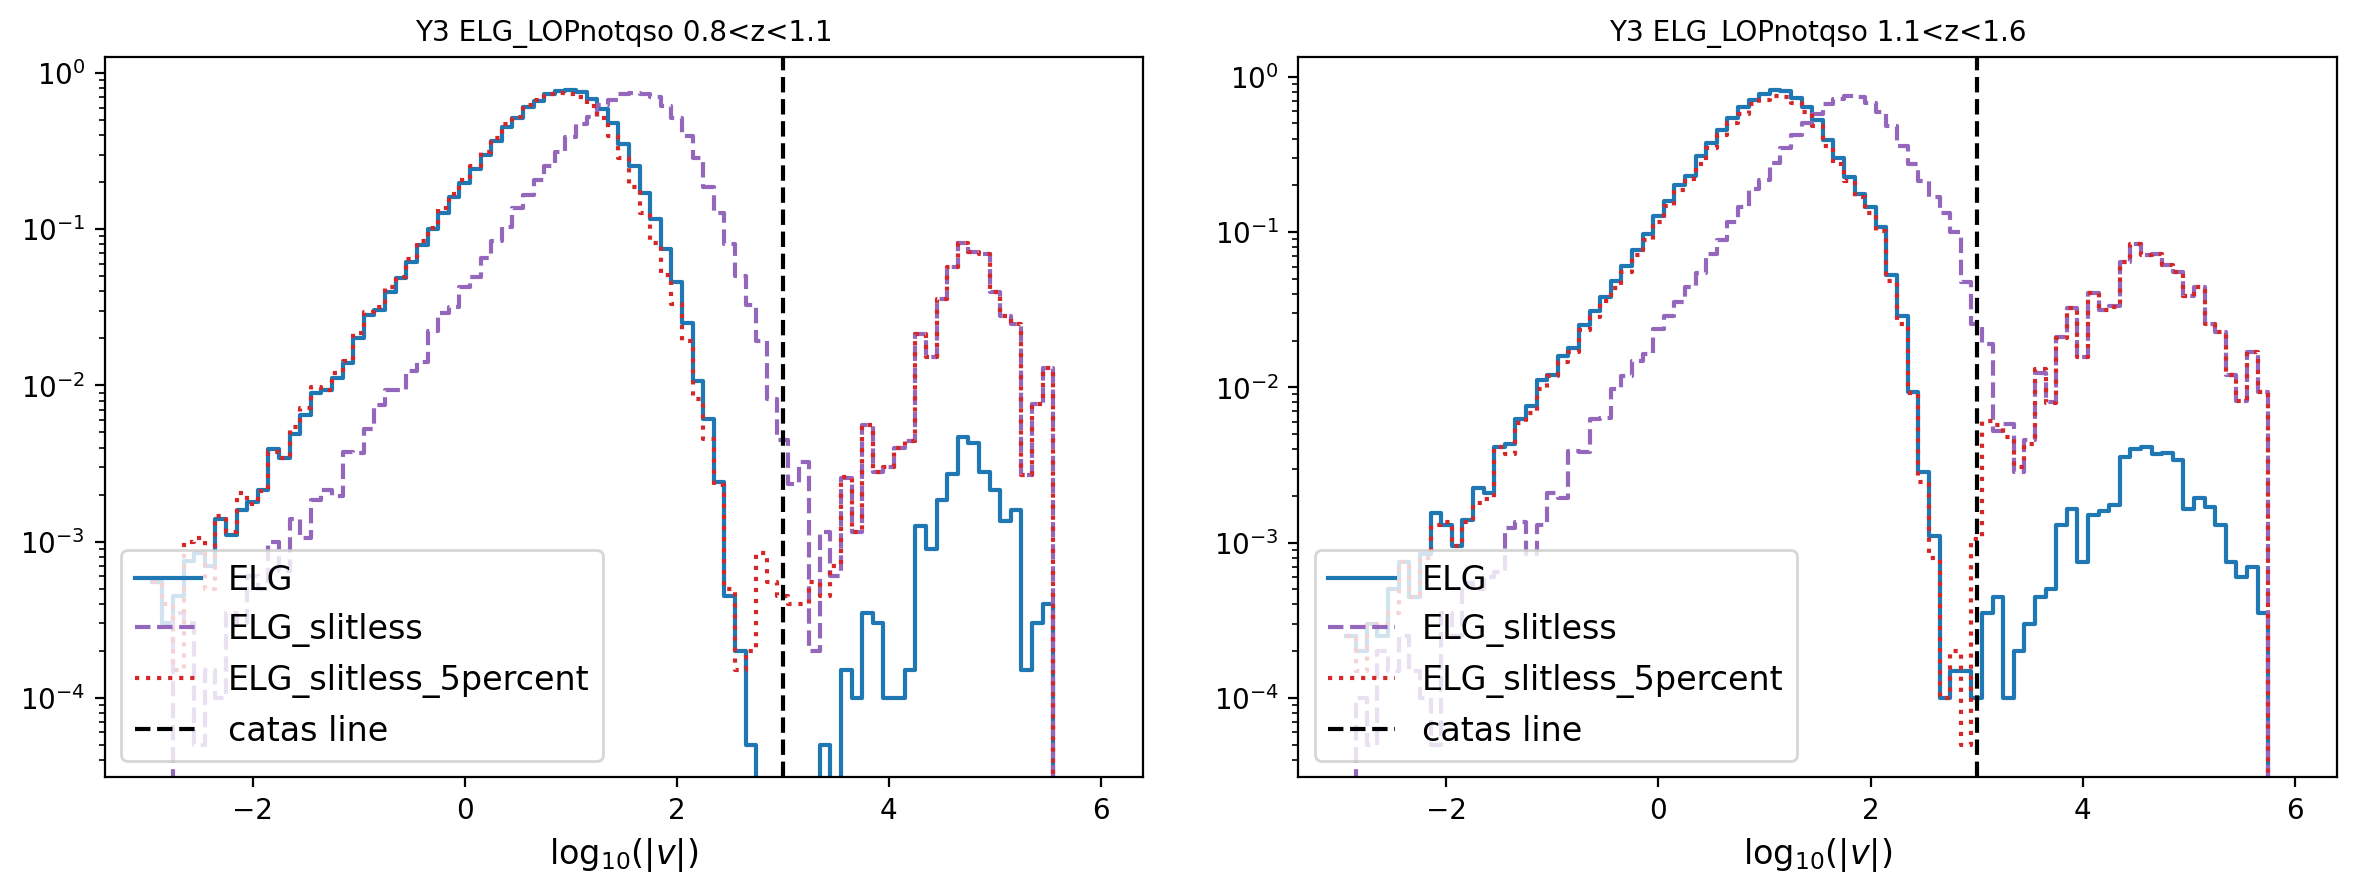

In [37]:
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1,2,wspace=0.15,hspace=0.1,left=0.05, right=0.98, top=0.95, bottom=0.05)

lss = ['-', '--', ':']
colors = ['C0','C4','C3']
zmins  = [0.8, 1.1]
zmaxs  = [1.1, 1.6] 
for zind,(zmin,zmax) in enumerate(zip(zmins,zmaxs)):
    catasmin, catasmax, catasbin = -3, 6.1, 0.1
    for i,tracer in enumerate(['ELG', 'ELG_slitless','ELG_slitless_5percent']):
        dv = vsmear(tracer, zmin=zmin, zmax=zmax, Ngal=400000, seed = 42)
        logdv = np.log10(abs(dv))
        dens, bins = np.histogram(logdv, bins=np.arange(catasmin,catasmax,catasbin), density= True)
        bins = (bins[1:]+bins[:-1])/2
        ax = plt.subplot(gs[zind])  
        plt.semilogy(bins, dens, drawstyle='steps-post', label=tracer, linestyle=lss[i], color = colors[i])
        plt.title(f'Y3 ELG_LOPnotqso {zmin:.1f}<z<{zmax:.1f}',fontsize=10)
    plt.axvline(x=3, color='black', linestyle='--', label='catas line')
    plt.xlabel(r'$\log_{10}(|v|)$')
    plt.yscale('log')
    plt.legend(loc=3)

## ----------------------------------------------------------------------------------------------
## ----------------------------------------------------------------------------------------------


[0.95242096 0.95242096 0.95242096 ... 0.95242096 0.95242096 0.95242096]


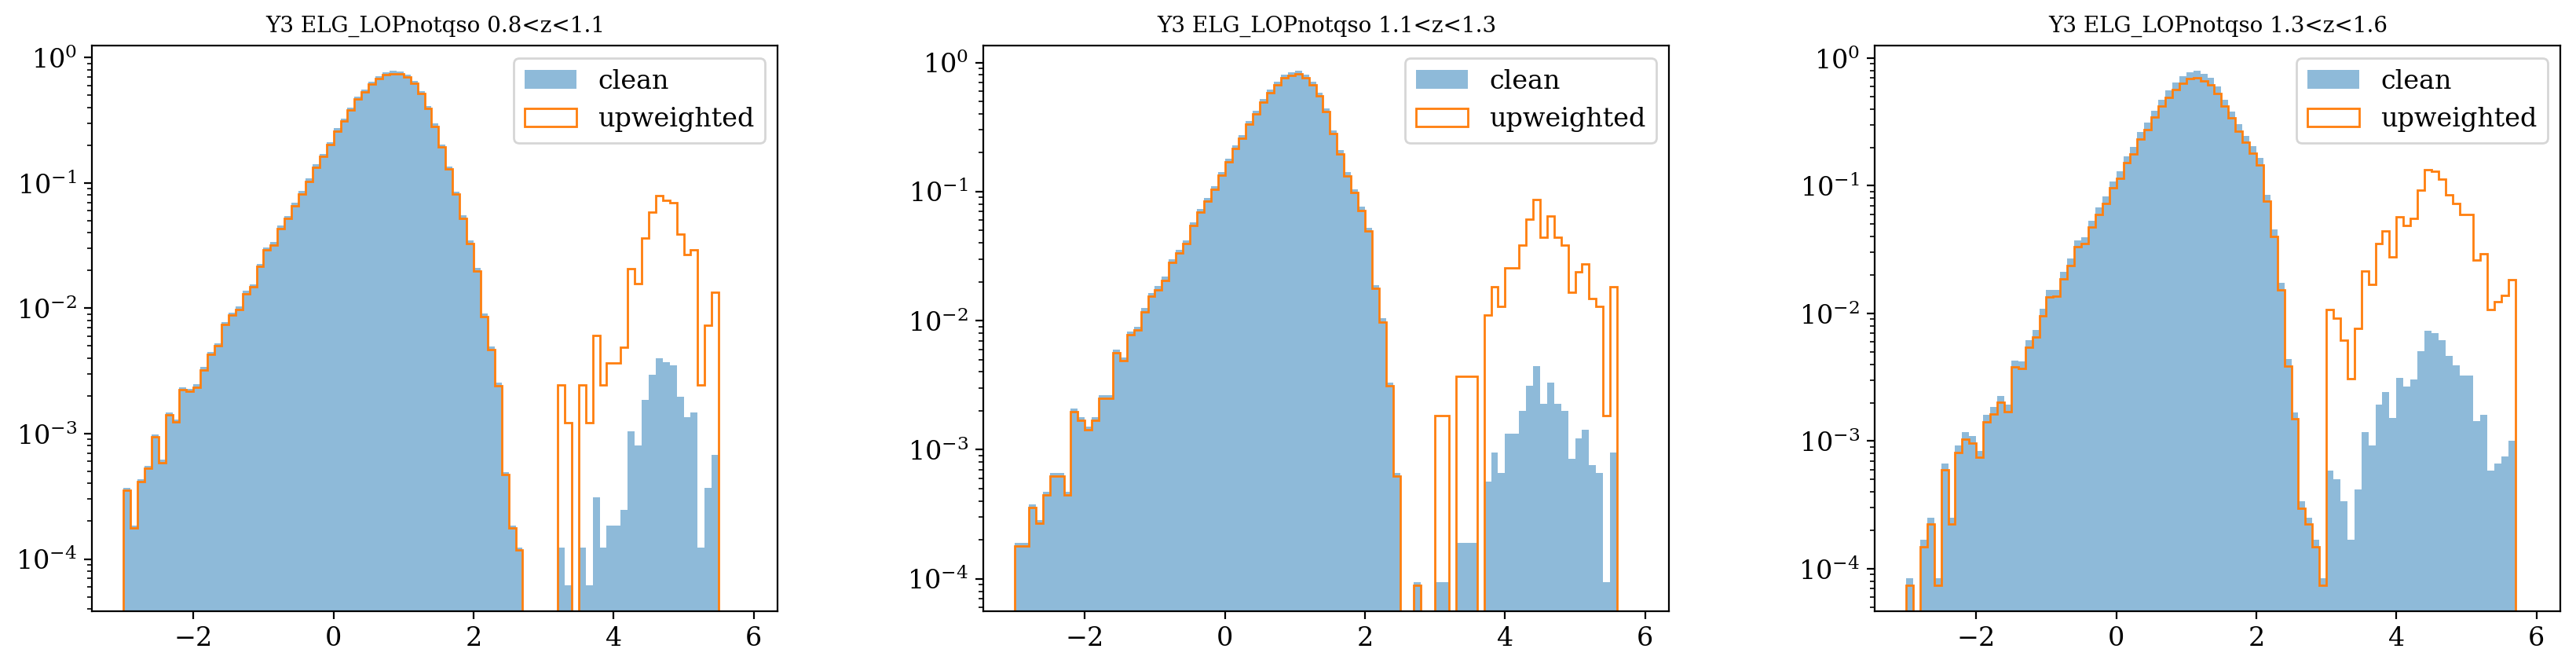

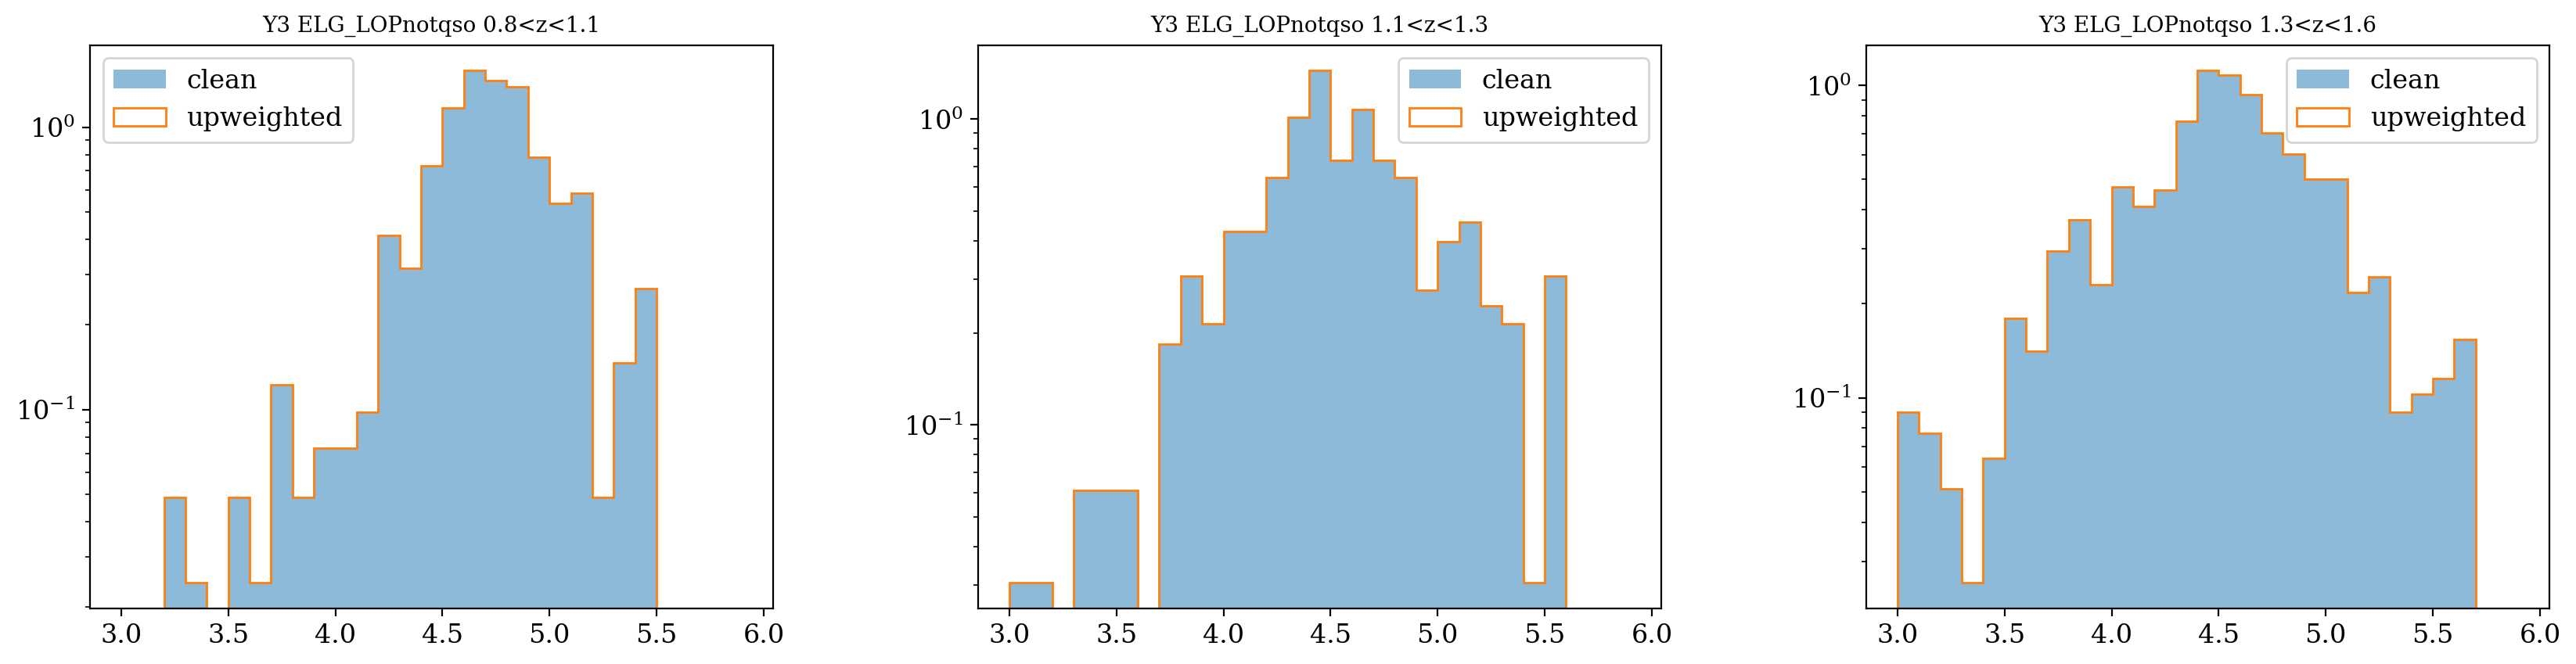

In [ ]:
from colormap import Colormap
# modify the current distribution to mimic space mission
## 5% catastrophics instead of 0.26%

repeatdir= f'/global/cfs/projectdirs/desi/users/jiaxiyu/repeated_observations/EDR_vs_Y3/LSS-scripts_repeats/main-repeats-kibo-dark-pairs.fits'
d        = Table.read(repeatdir)
mask, mask_key = desi_mask, "DESI_TARGET"
effkey, effmin, effmax, effxlim = (
    "TSNR2_LRG",
    0.85 * 1000,
    1.5 * 1000,
    (500, 1500),
)
# AR efftime_spec
snr2time = d.meta["{}SNR2T".format(effkey.split("_")[1])]
efftime0s = snr2time * d["{}_0".format(effkey)]
efftime1s = snr2time * d["{}_1".format(effkey)]

# AR zmtl_zwarn_mask nodata + bad
nodata0 = (d["ZMTL_ZWARN_0"] & zmtl_zwarn_mask["NODATA"]) > 0
nodata1 = (d["ZMTL_ZWARN_1"] & zmtl_zwarn_mask["NODATA"]) > 0
badqa0 = (d["ZMTL_ZWARN_0"] & zmtl_zwarn_mask.mask("BAD_SPECQA|BAD_PETALQA")) > 0
badqa1 = (d["ZMTL_ZWARN_1"] & zmtl_zwarn_mask.mask("BAD_SPECQA|BAD_PETALQA")) > 0

# select the valid pairs
sel = (d["COADD_FIBERSTATUS_0"] == 0) & (d["COADD_FIBERSTATUS_1"] == 0)
sel &= (~nodata0) & (~nodata1)
sel &= (~badqa0) & (~badqa1)
sel &= (efftime0s > effmin) & (efftime1s > effmin)
sel &= (efftime0s < effmax) & (efftime1s < effmax)
sel &= (d['SURVEY_0']=='main')&(d['SURVEY_1']=='main')

goodkey = f"GOOD_ELG"
sel_E = (d[mask_key] & mask['ELG_LOP']) > 0
sel_E &= (d["{}_0".format(goodkey)]) & (d["{}_1".format(goodkey)])
sel_E &= (~d["GOOD_QSO_0"]) & (~d["GOOD_QSO_1"])        

d = d[sel&sel_E]
# upweight the catastrophics
mask_dv = abs(d['DV'])<=1000
mask_catas = abs(d['DV'])>1000

# Desired proportions
desired_dv = 0.95  # 95%
desired_catas = 0.05  # 5%

# Compute weights
weights = np.where(mask_dv, desired_dv / mask_dv.mean(), desired_catas / mask_catas.mean())
        
# plot
plt.rc('font', family='serif', size=12) 
zmins  = [0.8,1.1,1.3]
zmaxs  = [1.1,1.3,1.6] 
# colors = Colormap(np.linspace(0, 1, len(zmins)+2))

catasmax  = 6
catasbin  = 0.1
for catasmin in [-3,3]:
    fig = plt.figure(figsize=(23, 4))
    gs = gridspec.GridSpec(1,4,wspace=0.3,hspace=0.1,left=0.05, right=0.98, top=0.95, bottom=0.05)
    for zind,(zmin,zmax) in enumerate(zip(zmins,zmaxs)):
        # AR cut on redshift range with a OR
        selz = ((zmin<d["Z_0"])&(d["Z_0"]<zmax))|((zmin<d["Z_1"])&(d["Z_1"]<zmax))
        dv_final = np.log10(abs(d['DV'][selz]))
        # subplot: where does catastrophics start? 
        ax = plt.subplot(gs[zind])
        plt.title(f'Y3 ELG_LOPnotqso {zmin:.1f}<z<{zmax:.1f}',fontsize=10)
        dens,bins,_=ax.hist(dv_final,bins=np.arange(catasmin,catasmax,catasbin),alpha=0.5,        density=True,label=f'clean')
        dens,bins,_=ax.hist(dv_final,bins=np.arange(catasmin,catasmax,catasbin),histtype='step',  density=True,label=f'upweighted',weights=weights[selz])
        plt.yscale('log')
        plt.legend()


In [ ]:
from desitarget.targetmask import desi_mask, bgs_mask
from desitarget.targetmask import zwarn_mask as zmtl_zwarn_mask

zmins  = [0.8, 1.1, 1.1, 1.3]
zmaxs  = [1.1, 1.6, 1.3, 1.6] 

fig = plt.figure(figsize=(22, 4))
gs = gridspec.GridSpec(1,4,wspace=0.15,hspace=0.1,left=0.05, right=0.98, top=0.95, bottom=0.05)
for zind,(zmin,zmax) in enumerate(zip(zmins,zmaxs)):
    # modify the current distribution to mimic space mission
    ## 5% catastrophics instead of 0.26%
    repeatdir= f'/global/cfs/projectdirs/desi/users/jiaxiyu/repeated_observations/EDR_vs_Y3/LSS-scripts_repeats/main-repeats-kibo-dark-pairs.fits'
    d        = Table.read(repeatdir)
    catasmin, catasmax, catasbin = -3, 6.1, 0.1

    mask, mask_key = desi_mask, "DESI_TARGET"
    effkey, effmin, effmax, effxlim = (
        "TSNR2_LRG",
        0.85 * 1000,
        1.5 * 1000,
        (500, 1500),
    )
    # AR efftime_spec
    snr2time = d.meta["{}SNR2T".format(effkey.split("_")[1])]
    efftime0s = snr2time * d["{}_0".format(effkey)]
    efftime1s = snr2time * d["{}_1".format(effkey)]

    # AR zmtl_zwarn_mask nodata + bad
    nodata0 = (d["ZMTL_ZWARN_0"] & zmtl_zwarn_mask["NODATA"]) > 0
    nodata1 = (d["ZMTL_ZWARN_1"] & zmtl_zwarn_mask["NODATA"]) > 0
    badqa0 = (d["ZMTL_ZWARN_0"] & zmtl_zwarn_mask.mask("BAD_SPECQA|BAD_PETALQA")) > 0
    badqa1 = (d["ZMTL_ZWARN_1"] & zmtl_zwarn_mask.mask("BAD_SPECQA|BAD_PETALQA")) > 0

    # select the valid pairs
    sel = (d["COADD_FIBERSTATUS_0"] == 0) & (d["COADD_FIBERSTATUS_1"] == 0)
    sel &= (~nodata0) & (~nodata1)
    sel &= (~badqa0) & (~badqa1)
    sel &= (efftime0s > effmin) & (efftime1s > effmin)
    sel &= (efftime0s < effmax) & (efftime1s < effmax)
    sel &= (d['SURVEY_0']=='main')&(d['SURVEY_1']=='main')

    # select good ELGs
    goodkey = f"GOOD_ELG"
    sel_E = (d[mask_key] & mask['ELG_LOP']) > 0
    sel_E &= (d["{}_0".format(goodkey)]) & (d["{}_1".format(goodkey)])
    sel_E &= (~d["GOOD_QSO_0"]) & (~d["GOOD_QSO_1"])        
    d = d[sel&sel_E]

    colors = ['C0','C3','C4']
    for i,ftype in enumerate(['ELG','ELG_slitless_5percent', 'ELG_slitless']):
        # cut on redshift range 
        selz = ((zmin<d["Z_0"])&(d["Z_0"]<zmax))|((zmin<d["Z_1"])&(d["Z_1"]<zmax))
        dv_final = np.log10(abs(d['DV'][selz]))  
            # provide the Delta_velocity distributions
        # type 1: upweight the catastrophics
        mask_dv = abs(d['DV'])<=1000
        mask_catas = abs(d['DV'])>1000
        ## Desired proportions
        desired_dv    = 1-desired_catas 
        lss = ['-', '--', ':']
        ## Compute weights and implement it to the distribution
        if ftype in [ 'ELG_slitless_5percent','ELG_slitless']:
            weights = np.where(mask_dv, desired_dv / mask_dv.mean(), desired_catas / mask_catas.mean())        
            if ftype == 'ELG_slitless':
                dv_final[dv_final<3] += np.log10(5)
        elif ftype in ['ELG']:
            weights = np.ones_like(d['DV'])

        # sel_clean = dens>0
        # vmid      = (bins[1:]+bins[:-1])/2
        # vmid      = vmid[sel_clean]
        # vbin_fine = 0.1
        # dens,bins=np.histogram(dv_final,bins=np.arange(catasmin,catasmax,catasbin),density=True,weights=weights[selz])
        # bins = (bins[1:]+bins[:-1])/2
        # dens,bins = np.histogram(dv_final,bins=np.arange(catasmin,catasmax,catasbin),density=True,weights=weights[selz]) 
# 
        # keep none-zero elements
        # sel_clean = dens>0
        # vmid      = (bins[1:]+bins[:-1])/2
        # vmid      = vmid[sel_clean]
        ## save the observed PDF and CDF
        dvfn = '/global/cfs/projectdirs/desi/users/jiaxiyu/repeated_observations/EDR_vs_Y3/LSS-scripts_repeats'
        cdffn_data= f'{dvfn}/{ftype}_z{zmin:.1f}-{zmax:.1f}_CDF'
        if not os.path.exists(cdffn_data+'.npz'):       
            vbin_fine = 0.005
            dens_fine,bins_fine=np.histogram(dv_final,bins=np.arange(catasmin,catasmax,vbin_fine),density=True,weights=weights[selz])
            cdf_data     = np.cumsum(dens_fine) * vbin_fine 
            np.savez(cdffn_data, vbin=(bins_fine[1:]+bins_fine[:-1])/2, pdf=dens_fine, cdf=cdf_data)
        # interpolation for the observed Delta_v distribution
        # vnewbin = 0.005
        # vnew    = np.arange(vmid[0]-catasbin/2,vmid[-1]+catasbin/2+0.01,vnewbin)
        # vnewmid = (vnew[1:]+vnew[:-1])/2
        # kernel  = 0.3
        # ## compute the modelled PDF and CDF and save them
        # cdffn= f'{dvfn}/{ftype}_z{zmin:.1f}-{zmax:.1f}_kernel{kernel}_CDF'
        # if not os.path.exists(cdffn+'.npz'):       
        #     interp  = gaussian_kde(dv_final, bw_method=kernel)
        #     pdf     = interp(vnewmid)
        #     cdf     = np.cumsum(pdf) * vnewbin
        #     np.savez(cdffn, vbin=vnewmid, pdf=pdf, cdf=cdf)
            
    #     ax = plt.subplot(gs[zind])  
    #     plt.semilogy(bins, dens, drawstyle='steps-post', label=ftype, linestyle=lss[i], color = colors[i])
    #     plt.title(f'Y3 ELG_LOPnotqso {zmin:.1f}<z<{zmax:.1f}',fontsize=10)
    # plt.axvline(x=3, color='black', linestyle='--', label='catas line')
    # plt.xlabel(r'$\log_{10}(|v|)$')
    # plt.yscale('log')
    # plt.legend(loc=3)

NameError: name 'desired_catas' is not defined

<Figure size 2200x400 with 0 Axes>

In [ ]:
from desitarget.targetmask import desi_mask, bgs_mask
from desitarget.targetmask import zwarn_mask as zmtl_zwarn_mask

tracer = 'QSO'
dvcatas  = 3000
# dvcatas  = 10000
survey = 'DR2'

if survey == 'DR2':
    RMSs = []
    fcs = []
    number = []
    # zmins = np.arange(0.55, 4.1, 0.1)
    # zmaxs = zmins+0.1
    zmins = [0.8, 1.1, 1.4, 1.7]
    zmaxs = [1.1, 1.4, 1.7, 2.1]
    for zind,(zmin,zmax) in enumerate(zip(zmins,zmaxs)):
    # print(zind, (zmin,zmax))
        repeatdir= f'/global/cfs/projectdirs/desi/users/jiaxiyu/repeated_observations/EDR_vs_Y3/LSS-scripts_repeats/main-repeats-kibo-dark-pairs_QSO.fits'
        d        = Table(fitsio.read(repeatdir))
        d        = d[~np.isnan(d['DV'])]
        sel      = np.full(len(d),True)
        # cut on redshift range 
        selz = ((zmin<d["Z_0"])&(d["Z_0"]<zmax))|((zmin<d["Z_1"])&(d["Z_1"]<zmax))
        selcata = abs(d["DV"]) < dvcatas
        dv_zbin = d['DV'][sel & selz]
        print(len(dv_zbin))
        dv_smear = d['DV'][sel & selz & selcata]
        fc = 1-len(dv_smear)/len(dv_zbin)
        RMS = np.sqrt(np.mean(dv_smear ** 2))
        RMSs.append(RMS)
        number.append(len(dv_smear))
        fcs.append(fc)
    # save = np.column_stack((np.array(zmins+zmaxs)/2, RMS, number))
    # np.savetxt(f'../results/DESI_{survey}_QSO_redshift_error_points.txt', save, 
    #         header="redshift, RMS of vsmear(km/s), number of repeat observation pairs", delimiter=", ", fmt="%.2f, %.8f, %i")
if survey == 'EDR':
    RMS = []
    number = []
    # zmins = np.arange(0.75, 3.55, 0.1)
    zmins = np.arange(0.75, 2.15, 0.1)
    zmaxs = zmins+0.1
    for zind,(zmin,zmax) in enumerate(zip(zmins,zmaxs)):
        repeatdir= f'/global/cfs/projectdirs/desi/users/jiaxiyu/repeated_observations/EDR/QSO_dv.fits'
        d        = Table.read(repeatdir)
        d        = d[~np.isnan(d['DV'])]
        sel      = np.full(len(d),True)
        selz = ((zmin<d["Z_0"])&(d["Z_0"]<zmax))|((zmin<d["Z_1"])&(d["Z_1"]<zmax))
        selcata = abs(d["DV"]) < dvcatas
        dv = d['DV'][sel & selz & selcata]
        RMS.append(np.sqrt(np.mean(dv ** 2)))
        number.append(len(dv))
    zmean = np.array(zmins+zmaxs)/2
    table = np.column_stack((zmean, number, RMS)).T
    # save = np.column_stack((np.array(zmins+zmaxs)/2, RMS, number))
    # np.savetxt(f'../results/DESI_{survey}_QSO_redshift_error_points.txt', save, 
    #         header="redshift, RMS of vsmear(km/s), number of repeat observation pairs", delimiter=", ", fmt="%.2f, %.8f, %i")

35141
194.8630878832419
53478
242.5161754097813
68460
462.62800978649545
121444
488.2101577675907


In [24]:
# Print with formatting
from tabulate import tabulate
zlabels = [f"z{zmin:.1f}-{zmax:.1f}" for zmin, zmax in zip(zmins, zmaxs)]
RMS_label = [f"{r:.1f}" for r in RMSs]
fcs_label = [f"{r*100:.3}%" for r in fcs]
# Create inverse table (each list is a row)
table_print = [
    [""] + list(zlabels),
    ["DR2 RMS"] + list(RMS_label),
    ["DR2 fc"] + list(fcs_label),
    ["Repeat num"] + list(number),
]
# Print with grid
colalign = ["center"] * len(table_print[0])
print(tabulate(table_print, headers="firstrow", tablefmt="grid",colalign=colalign))

+------------+------------+------------+------------+------------+
|            |  z0.8-1.1  |  z1.1-1.4  |  z1.4-1.7  |  z1.7-2.1  |
+============+============+============+============+============+
|  DR2 RMS   |   252.9    |   379.8    |   571.4    |   614.7    |
+------------+------------+------------+------------+------------+
|   DR2 fc   |   3.08%    |   1.46%    |   1.78%    |   0.889%   |
+------------+------------+------------+------------+------------+
| Repeat num |   34059    |   52695    |   67244    |   120364   |
+------------+------------+------------+------------+------------+


In [38]:
file_path = "../results/eBOSS_redshift_error_points.txt"

data_rounded = """
x, y
1.00, 292.05128205128204
1.10, 286.21794871794873
1.20, 274.55128205128204
1.30, 288.9102564102564
1.40, 292.05128205128204
1.50, 298.3333333333333
1.60, 326.1538461538462
1.70, 367.88461538461536
1.80, 405.5769230769231
1.90, 408.71794871794873
2.00, 459.4230769230769
2.10, 483.6538461538462
"""

# Save the data to a text file
with open(file_path, "w") as file:
    file.write(data_rounded.strip())